In [1]:
#Setting up paths for data
data_root = "/home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification" 

tr_base  = data_root+"/Training"
te_base  = data_root+"/Testing"

In [2]:
#Setting up Transforms 
from pathlib import Path
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler # remember subset when you divide into training and validation
from torchvision import datasets, transforms, utils, models # add models when you import pretrained models for transfer learning
import os
import torch
import numpy as np

IMG_SIZE = 512

def zscore(x):  # MRI-friendly
    return (x - x.mean()) / (x.std() + 1e-8)

train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),                 # use 'RGB' if truly 3-ch
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.02,0.02), scale=(0.95,1.05)),
    transforms.RandomApply([transforms.GaussianBlur(3, (0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

In [3]:
trainset=datasets.ImageFolder(tr_base, transform=train_tf)
valset = datasets.ImageFolder(tr_base, transform=eval_tf)
testset=datasets.ImageFolder(te_base, transform=eval_tf)


print(testset.classes)
print(trainset.classes)
print(valset.classes)

val_fraction=0.2

idxs = list(range(len(valset)))
rng = np.random.default_rng(42)
rng.shuffle(idxs)

n_val = int(len(idxs) * val_fraction)
val_idx = idxs[:n_val]
train_idx = idxs[n_val:]

trainset = Subset(trainset, train_idx)
valset   = Subset(valset,   val_idx)

class_names = datasets.ImageFolder(tr_base).classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
def get_targets_from_dataset(ds) -> np.ndarray:
    """Return class indices for ImageFolder or Subset(ImageFolder)."""
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        if hasattr(base, "targets"):
            return np.asarray(base.targets, dtype=int)[idxs]
        return np.asarray([base.samples[i][1] for i in idxs], dtype=int)
    # ImageFolder
    if hasattr(ds, "targets"):
        return np.asarray(ds.targets, dtype=int)
    return np.asarray([y for _, y in ds.samples], dtype=int)

In [5]:

# assume you already created trainset (ImageFolder or Subset(ImageFolder))
targets = get_targets_from_dataset(trainset)              # shape [N]
num_classes = int(targets.max() + 1)

# inverse-frequency class weights (simple & effective)
class_counts  = np.bincount(targets, minlength=num_classes).astype(float)
class_weights = 1.0 / np.maximum(class_counts, 1.0)      # avoid div/0
sample_weights = class_weights[targets]                   # per-sample weight

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),   # one epoch ~= dataset size
    replacement=True                   # allows oversampling of minority class
)

BATCH = 4
WORKERS = 4


train_loader = DataLoader(
    trainset,
    batch_size=BATCH,
    shuffle=False,
    sampler=sampler,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=True,                    # optional: keeps batch size stable
)

# validation/test loaders stay standard (no sampler)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=WORKERS, pin_memory=True)

In [6]:
from torchvision import models

print(models.list_models())

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def _get_pos_embed_param(model):
    """
    Find the positional embedding parameter across torchvision versions.
    Returns (module_ref, attr_name, tensor) so we can assign back.
    """
    # Common locations across versions
    candidates = [
        ("pos_embed", getattr(model, "pos_embed", None)),
        ("pos_embedding", getattr(model, "pos_embedding", None)),
        # encoder.* in many torchvision ViT builds
        ("encoder.pos_embedding", getattr(getattr(model, "encoder", None), "pos_embedding", None)
         if hasattr(model, "encoder") else None),
        ("encoder.pos_embed", getattr(getattr(model, "encoder", None), "pos_embed", None)
         if hasattr(model, "encoder") else None),
    ]
    for name, val in candidates:
        if isinstance(val, torch.nn.Parameter):
            # Return a reference to the parent module + attribute name
            if "." in name:
                parent_name, child_name = name.split(".", 1)
                parent = getattr(model, parent_name)
                return parent, child_name, val
            else:
                return model, name, val
    raise AttributeError("Could not locate positional embedding parameter on this VisionTransformer.")

@torch.no_grad()
def resize_vit_pos_embed(model, new_size):
    """
    Bicubic-interpolate the grid part of the ViT positional embeddings to `new_size` (H, W).
    Works for torchvision ViT (e.g., vit_l_32) and keeps the class token intact.
    """
    H, W = (new_size, new_size) if isinstance(new_size, int) else new_size

    # Patch size (e.g., 32 for vit_l_32)
    patch = getattr(model, "patch_size", None)
    if patch is None:
        # Torchvision stores it here:
        patch = getattr(getattr(model, "conv_proj", None), "kernel_size", None)
        if isinstance(patch, tuple):
            patch = patch[0]
    if patch is None:
        raise AttributeError("Could not determine patch size for this ViT.")

    gh_new, gw_new = H // patch, W // patch  # new grid (tokens) size
    parent, attr_name, pos_embed = _get_pos_embed_param(model)  # (1, 1+N, D)

    # Split class token and grid tokens
    cls_tok = pos_embed[:, :1, :]                      # (1, 1, D)
    grid_tok = pos_embed[:, 1:, :]                     # (1, N, D)
    D = grid_tok.shape[-1]

    # Infer old grid size
    N = grid_tok.shape[1]
    gh_old = gw_old = int(N**0.5)
    if gh_old * gw_old != N:
        raise ValueError(f"Cannot infer square grid from N={N} tokens.")

    # Reshape to 2D grid: (1, D, gh_old, gw_old)
    grid_2d = grid_tok.reshape(1, gh_old, gw_old, D).permute(0, 3, 1, 2)

    # Bicubic interpolate to new grid size
    grid_2d_resized = F.interpolate(grid_2d, size=(gh_new, gw_new), mode="bicubic", align_corners=False)

    # Back to (1, gh_new*gw_new, D)
    grid_tok_resized = grid_2d_resized.permute(0, 2, 3, 1).reshape(1, gh_new * gw_new, D)

    # Concatenate class token back
    new_pos_embed = torch.cat([cls_tok, grid_tok_resized], dim=1)

    # Assign back as a Parameter
    setattr(parent, attr_name, nn.Parameter(new_pos_embed))

    # Update model’s internal image size check (used by forward)
    if hasattr(model, "image_size"):
        model.image_size = H

def build_model(n_classes, img_size=512, freeze_backbone=False):
    # 1) Load pretrained ViT-L/32 (224×224)
    model = models.vit_l_32(weights=models.ViT_L_32_Weights.IMAGENET1K_V1)

    # 2) Resize positional embeddings and update size check
    resize_vit_pos_embed(model, (img_size, img_size))

    # 3) Replace classifier head (torchvision uses heads.head)
    in_feats = model.heads.head.in_features
    model.heads.head = nn.Linear(in_feats, n_classes)

    # 4) Optional: freeze backbone, keep head trainable
    if freeze_backbone:
        for p in model.parameters():
            p.requires_grad = False
        for p in model.heads.parameters():
            p.requires_grad = True

    return model


model = build_model(n_classes=4, img_size=512, freeze_backbone=False)
print(model)

# Verify output
import torch
x = torch.randn(2, 3, 512, 512)
out = model(x)
print(out.shape)  # → [2, 4]


VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [8]:
# ----------------------------
# 3) Training utilities
# ----------------------------
class EarlyStopper:
    def __init__(self, patience=8, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, metric):
        if self.best is None or metric > self.best + self.min_delta:
            self.best = metric
            self.count = 0
            return False  # do not stop

In [9]:
import contextlib
import torch
import torch.nn.functional as F

def epoch_run(model, loader, criterion, device, train: bool, use_amp: bool,
              optimizer=None, scaler=None):
    assert (train and optimizer is not None and scaler is not None) or (not train)

    model.train() if train else model.eval()

    total = 0
    running_loss = 0.0
    correct = 0

    # no graph during evaluation
    cm = contextlib.nullcontext() if train else torch.no_grad()

    with cm:
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=(use_amp and device.type == 'cuda')):
                logits = model(xb)
                loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            running_loss += loss.detach().float().item() * xb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

    return running_loss / total, correct / total


In [10]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(batch, device):
    x, y = batch
    return x.to(device, non_blocking=True), y.to(device, non_blocking=True)

Device: cuda
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Train uses sampler: WeightedRandomSampler
Val uses sampler:   SequentialSampler
Test uses sampler:  SequentialSampler
Epoch 01/500 | train_loss=1.3322 acc=0.4003 | val_loss=1.1055 acc=0.5583 🟢⭐ (new best loss & acc)
Epoch 02/500 | train_loss=1.1288 acc=0.5423 | val_loss=1.0739 acc=0.5913 🟢⭐ (new best loss & acc)
Epoch 03/500 | train_loss=1.0898 acc=0.5675 | val_loss=1.0664 acc=0.5530 ✅ (new best loss)
Epoch 04/500 | train_loss=1.0149 acc=0.6079 | val_loss=0.9731 acc=0.5687 ✅ (new best loss)
Epoch 05/500 | train_loss=0.9215 acc=0.6461 | val_loss=0.9247 acc=0.6348 🟢⭐ (new best loss & acc)
Epoch 06/500 | train_loss=0.8853 acc=0.6665 | val_loss=0.8541 acc=0.6591 🟢⭐ (new best loss & acc)
Epoch 07/500 | train_loss=0.8593 acc=0.6769 | val_loss=0.9380 acc=0.6157
Epoch 08/500 | train_loss=0.8088 acc=0.6987 | val_loss=0.9633 acc=0.5774
Epoch 09/500 | train_loss=0.7955 acc=0.7069 | val_loss=1.0293 acc=0.5513

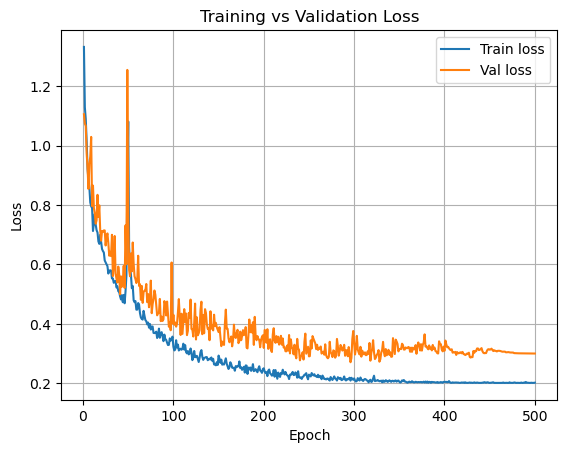

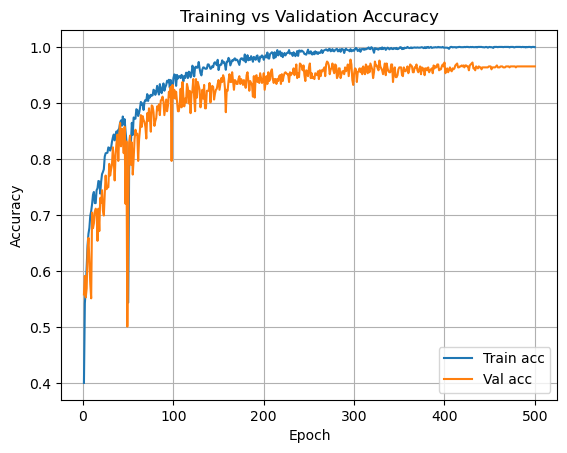

/tmp/ipykernel_129/3462939162.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.2100    0.3471       100
meningioma_tumor     0.6894    0.9652    0.8043       115
        no_tumor     0.6825    1.0000    0.8113       129
 pituitary_tumor     0.9149    0.5811    0.7107        74

        accuracy                         0.7273       418
       macro avg     0.8217    0.6891    0.6684       418
    weighted avg     0.8015    0.7273    0.6805       418


Confusion matrix:
[[ 21  35  41   3]
 [  0 111   3   1]
 [  0   0 129   0]
 [  0  15  16  43]]


In [18]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch import amp
import json

seed=2025
set_seed(seed)
device = get_device()
print("Device:", device)

DATA_ROOT = data_root 
BATCH = 32
EPOCHS = 500
LR = 3e-4
FREEZE_BACKBONE = False  # set True to train only the last layer first

#trainset, valset, testset, class_names = build_datasets(DATA_ROOT, img_size=224, val_fraction=0.15)
print("Classes:", class_names)

scaler = amp.GradScaler('cuda', enabled=(device.type=='cuda'))

train_loader = DataLoader(trainset,batch_size=BATCH,sampler=sampler,num_workers=WORKERS,pin_memory=True)                    # optional: keeps batch size stable)
val_loader = DataLoader(valset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)
test_loader = DataLoader(testset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   

print("Train uses sampler:", train_loader.sampler.__class__.__name__)
print("Val uses sampler:  ", val_loader.sampler.__class__.__name__)
print("Test uses sampler: ", test_loader.sampler.__class__.__name__)

model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {
    "train_loss": [],
    "val_loss":   [],
    "train_acc":  [],
    "val_acc":    [],
}


best_loss, best_acc, best_path, best_path_acc = 1000, 0.0, "best_ViT_Loss_brain_tumor.pt", "best_ViT_Acc_brain_tumor.pt"
stopper = EarlyStopper(patience=7, min_delta=1e-4)

for epoch in range(1, EPOCHS+1):
    #train_loss, train_acc = epoch_run(model, train_loader, criterion, device, train=True, use_amp=True)
    #val_loss,   val_acc   = epoch_run(model, val_loader,   criterion, device, train=False, use_amp=True)
    
    train_loss, train_acc = epoch_run(model, train_loader, criterion, device, train=True, use_amp=True, optimizer=optimizer, scaler=scaler)
    val_loss,   val_acc   = epoch_run(model, val_loader,   criterion, device, train=False, use_amp=True)
    #scheduler.step(val_loss)
    scheduler.step()

    # log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    color = ""
    end_color = "\033[0m"
    style_bold = "\033[1m"
    suffix = ""

    # Check for improvements
    if val_loss < best_loss and val_acc > best_acc:
        best_loss = val_loss
        best_acc = val_acc
        color = "\033[96m"  # cyan if both improve
        suffix = " 🟢⭐ (new best loss & acc)"
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path)

    elif val_loss < best_loss:
        best_loss = val_loss
        color = "\033[92m"  # green for best loss
        suffix = " ✅ (new best loss)"
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path)
    elif val_acc > best_acc:
        best_acc = val_acc
        color = "\033[94m"  # blue for best acc
        suffix = " 💙 (new best acc)"
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path_acc)

    # Print the formatted line
    print(f"{color}{style_bold}"
          f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
          f"{suffix}{end_color}")


    if stopper.step(val_acc):
        print("Early stopping triggered.")
        break


print(f"Best val loss: {best_loss:.4f}. Saved to: {best_path}")

with open("history_ViT.json", "w") as f:
    json.dump(history, f)


# ---- after training: plots ----
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# (optional) accuracy plot
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
# ----------------------------
# Evaluation on test (if available)
# ----------------------------
if test_loader is not None:
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))




In [18]:
from sklearn.metrics import classification_report, confusion_matrix
best_path_acc =  "best_SwinTrans_Acc_brain_tumor.pt"
device = get_device()
print("Device:", device)
BATCH=32
FREEZE_BACKBONE=False
model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)
test_loader = DataLoader(testset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   


if test_loader is not None:
    ckpt = torch.load(best_path_acc, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Evaluated {len(y_true)} / {len(testset)} samples")


Device: cuda


/tmp/ipykernel_20325/3705843089.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path_acc, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.3300    0.4962       100
meningioma_tumor     0.7143    1.0000    0.8333       115
        no_tumor     0.7914    1.0000    0.8836       129
 pituitary_tumor     0.9672    0.7973    0.8741        74

        accuracy                         0.8038       418
       macro avg     0.8682    0.7818    0.7718       418
    weighted avg     0.8512    0.8038    0.7754       418


Confusion matrix:
[[ 33  37  28   2]
 [  0 115   0   0]
 [  0   0 129   0]
 [  0   9   6  59]]
Evaluated 418 / 418 samples


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
best_path_acc =  "best_ViT_Acc_brain_tumor.pt"
device = get_device()
print("Device:", device)
BATCH=32
FREEZE_BACKBONE=False
model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)
test_loader = DataLoader(valset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   


if test_loader is not None:
    ckpt = torch.load(best_path_acc, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"Evaluated {len(y_true)} / {len(valset)} samples")


Device: cuda


/tmp/ipykernel_20325/1101011654.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path_acc, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    1.0000    1.0000       158
meningioma_tumor     0.9941    1.0000    0.9971       169
        no_tumor     1.0000    1.0000    1.0000        73
 pituitary_tumor     1.0000    0.9943    0.9971       175

        accuracy                         0.9983       575
       macro avg     0.9985    0.9986    0.9985       575
    weighted avg     0.9983    0.9983    0.9983       575


Confusion matrix:
[[158   0   0   0]
 [  0 169   0   0]
 [  0   0  73   0]
 [  0   1   0 174]]
Evaluated 575 / 575 samples
